# $W_{0,\mathrm{opt}}$

In [2]:
# import API
import pwpp
from pwpp import *
import pickle
filename='Optimum'

In [ ]:
# load
infile = open(filename,'rb')
W0lst, NpW0_s, Np_smpl_s, Elst, W0opt_th = pickle.load(infile)
infile.close()

In [21]:
# parameters
# laser
lbd = 0.8; #[\mu m]
tau = 150; #[fs] 35
w0 = 2*pi*c/(lbd*1e-6)*hbar/e*1e-9; #[GeV]
n = tau*c/(lbd*1e-6)*1e-15; #[]
W0lst = np.linspace(2,10,50); #[\mu m] 50
# beam
E0 = 10; #[GeV]
g0 = E0/m; #[]
sigmax = 24.4; #[\mu m]
sigmay = 29.6; #[\mu m]
R = (sigmax+sigmay)/2*sqrt(2); #[\mu m]
L = 200; #[\mu m]
nb = 1e16; #[cm^-3]
nb = nb * 1e-12; #[\mu m^-3]
Nb = nb*(pi*R**2*L); #[]

# $N_+(W_0)$

In [ ]:
E = 1000; #[J] energy
a0max = sqrt(E/tau/(2.149e-5))*(lbd/min(W0lst)); #[]
# Interpolate N+
amin = 1
a0int = np.linspace(amin,a0max,200); #[]
Npint = np.array([Np(g0, a, w0, n)[0] for a in a0int])
Npinterp1d = interpolate.interp1d(a0int, Npint)

# analytical distribution
def dNda(a,a0,W0):
    """theory"""
    zR = pi*W0**2/lbd; #[\mu m]
    az = a0/sqrt(1+(L/4/zR)**2)
    return np.piecewise(a, [a > az, a <= az], [lambda a: 4*pi*nb*W0**2*zR/a * 1/3/a * sqrt(a0**2-a**2) * ((a0/a)**2+2),
                                               lambda a: 4*pi*nb*W0**2*zR/a * L/4/zR * (1+(L/4/zR)**2/3) ])

In [22]:
# sampling
NpW0_s = np.zeros(len(W0lst));
Np_smpl_s = np.zeros(len(W0lst));
Nsmpl = int(1e6); #[]
zmax = +L/4 ; #[\mu m]
zmin = zmax-L/2; #[\mu m]
# coordinate data
zdist = (zmax-zmin)*rng.random(Nsmpl) + zmin; #[\mu m]
xdist = sigmax*rng.standard_normal(Nsmpl) #[\mu m]
ydist = sigmay*rng.standard_normal(Nsmpl) #[\mu m]

for i in trange(len(W0lst)):
    W0 = W0lst[i]; #[\mu m]
    a0 = sqrt(E/tau/(2.149e-5))*(lbd/W0); #[]
    
    # model
    alst = np.linspace(amin,a0,300);
    dNp = Npinterp1d(alst);
    ddNda = dNda(alst,a0,W0);
    NpW0_s[i] = np.trapz(ddNda * dNp, alst)
    #quad(lambda a: dNda(a,a0,W0) * Np(g0,a,w0,n) ,amin,0.999*a0)[0]
    
    # sampling
    adist = gauss3D(zdist, xdist, ydist, a0, W0, lbd)
    adist2 = adist[adist > amin]
    dNp = np.array([Npinterp1d(a) for a in adist2 ])
    Np_smpl_s[i] = np.sum( dNp ) * Nb/Nsmpl

# $W_{0,\mathrm{opt}}(\varepsilon)$

In [ ]:
Elst = np.linspace(500,1500,10) #[J]
W0opt_th = np.zeros(len(Elst))
W0opt_smpl = np.zeros(len(Elst))

In [32]:
for j in trange(len(Elst)):
    E = Elst[j]; #[J] energy
    a0max = sqrt(E/tau/(2.149e-5))*(lbd/min(W0lst)); #[]
    # Interpolate N+
    amin = 1
    a0int = np.linspace(amin,a0max,200);
    Npint = np.array([Np(g0, a, w0, n)[0] for a in a0int])
    Npinterp1d = interpolate.interp1d(a0int, Npint)

    # analytical distribution
    def dNda(a,a0,W0):
        """theory"""
        zR = pi*W0**2/lbd; #[\mu m]
        az = a0/sqrt(1+(L/4/zR)**2)
        return np.piecewise(a, [a > az, a <= az], [lambda a: 4*pi*nb*W0**2*zR/a * 1/3/a * sqrt(a0**2-a**2) * ((a0/a)**2+2),
                                                   lambda a: 4*pi*nb*W0**2*zR/a * L/4/zR * (1+(L/4/zR)**2/3) ])

    # simulation parameters
    Nsmpl = int(1e6); #[] 1e6
    zmax = +L/4 ; #[\mu m]
    zmin = zmax-L/2; #[\mu m]
    # coordinate data
    zdist = (zmax-zmin)*rng.random(Nsmpl) + zmin; #[\mu m]
    xdist = sigmax*rng.standard_normal(Nsmpl) #[\mu m]
    ydist = sigmay*rng.standard_normal(Nsmpl) #[\mu m]
    NpW0 = np.zeros(len(W0lst));
    Np_smpl = np.zeros(len(W0lst));
    for i in range(len(W0lst)):
        W0 = W0lst[i]; #[\mu m]
        a0 = sqrt(E/tau/(2.149e-5))*(lbd/W0); #[]
        
        # model
        alst = np.linspace(amin,a0,300);
        dNp = Npinterp1d(alst);
        ddNda = dNda(alst,0.99*a0,W0);
        NpW0[i] = np.trapz(ddNda * dNp, alst)

        # sampling
        adist = gauss3D(zdist, xdist, ydist, a0, W0, lbd)
        adist2 = adist[adist > amin]
        dNp = np.array([Npinterp1d(a) for a in adist2 ])
        Np_smpl[i] = np.sum( dNp ) * Nb/Nsmpl

    W0opt_th[j], W0opt_smpl[j] = W0lst[np.argmax(NpW0)], W0lst[np.argmax(Np_smpl)]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt


In [45]:
# save
outfile = open(filename,'wb')
pickle.dump([W0lst, NpW0_s, Np_smpl_s, Elst, W0opt_th],outfile)
outfile.close()

In [ ]:
plt.style.use("style.txt")
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,3.2))

plt.subplot(121)
plt.plot(W0lst,NpW0_s, 'k-', label='Theory');
plt.plot(W0lst[::4],Np_smpl_s[::4],'.', label='Sampling');
plt.xlabel(r'$W_0[\mu \mathrm{m}]$')
plt.ylabel(r'$N_+ \left[ \frac{n_b}{10^{16}~ \mathrm{cm}^{-3}} \right]$',labelpad=15)
plt.ylim([0.9e8,1.6e8])
plt.xlim([2.8,10.1])
plt.legend(frameon=False)
plt.tick_params(which='both',axis="y",direction="in", labelleft=True, labelright=False, left=True, right=True)
plt.tick_params(which='both',axis="x",direction="in", labeltop=False, labelbottom=True, top=True, bottom=True)
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(g))
axes[0].set_aspect(aspect=4/3)

plt.subplot(122)
plt.plot(Elst,W0opt_th, 'k-', label='Theory');
plt.plot(Elst,W0opt_smpl,'.', label='Sampling');
plt.xlabel(r'$\varepsilon[\mathrm{J}]$')
plt.ylabel(r'$W_{0,\mathrm{opt}}[\mu \mathrm{m}]$')
plt.legend(frameon=False,loc='upper left')
plt.ylim([2,8])
plt.xlim([460,1540])
plt.tick_params(which='both',axis="y",direction="in", labelleft=True, labelright=False, left=True, right=True)
plt.tick_params(which='both',axis="x",direction="in", labeltop=False, labelbottom=True, top=True, bottom=True)
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(g))
axes[1].set_aspect(aspect=4/3)

plt.tight_layout()
#plt.savefig('opt_ELI.pdf')
plt.show()

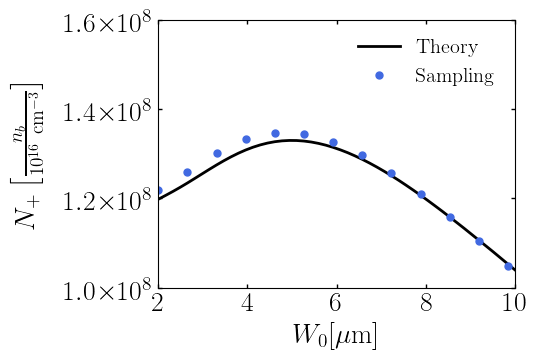

In [48]:
plt.style.use("style.txt")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

plt.plot(W0lst,NpW0_s, 'k-', label='Theory');
plt.plot(W0lst[::4],Np_smpl_s[::4],'.', label='Sampling');
plt.xlabel(r'$W_0[\mu \mathrm{m}]$')
plt.ylabel(r'$N_+ \left[ \frac{n_b}{10^{16}~ \mathrm{cm}^{-3}} \right]$',labelpad=15)
plt.legend(frameon=False)
plt.tick_params(which='both',axis="y",direction="in", labelleft=True, labelright=False, left=True, right=True)
plt.tick_params(which='both',axis="x",direction="in", labeltop=False, labelbottom=True, top=True, bottom=True)
plt.ylim([1e8,1.6e8])
plt.xlim([2,10])
plt.xticks([2,4,6,8,10])
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.1e"))
# aspect
xmin, xmax = axes.get_xlim()
ymin, ymax = axes.get_ylim()
axesratio = (ymax-ymin)/(xmax-xmin)
axes.set_aspect(aspect=3/4/axesratio)
# final
plt.tight_layout()
plt.savefig('Optimum_a.pdf')
plt.show()

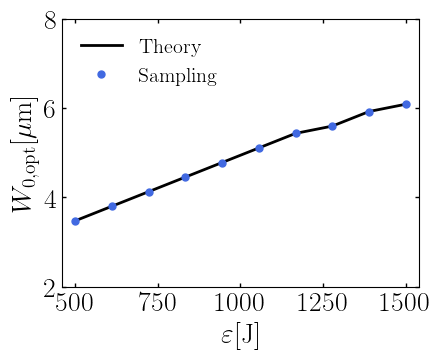

In [47]:
plt.style.use("style.txt")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

plt.plot(Elst,W0opt_th, 'k-', label='Theory');
plt.plot(Elst,W0opt_smpl,'.', label='Sampling');
plt.xlabel(r'$\varepsilon[\mathrm{J}]$')
plt.ylabel(r'$W_{0,\mathrm{opt}}[\mu \mathrm{m}]$')
plt.legend(frameon=False,loc='upper left')
plt.tick_params(which='both',axis="y",direction="in", labelleft=True, labelright=False, left=True, right=True)
plt.tick_params(which='both',axis="x",direction="in", labeltop=False, labelbottom=True, top=True, bottom=True)
plt.ylim([2,8])
plt.xlim([460,1540])
plt.xticks([500,750,1000,1250,1500])
plt.yticks([2,4,6,8])
# aspect
xmin, xmax = axes.get_xlim()
ymin, ymax = axes.get_ylim()
axesratio = (ymax-ymin)/(xmax-xmin)
axes.set_aspect(aspect=3/4/axesratio)
# final
plt.tight_layout()
plt.savefig('Optimum_b.pdf')
plt.show()